In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.datasets import fashion_mnist

# Load the MNIST data.
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# If subtract pixel mean is enabled
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Input image dimensions.
input_shape = x_train.shape[1:]

Using TensorFlow backend.


The depth of the network can be changed with parameter n.
The fuzzy classifier can be changed with the use_anfis parameter.

In [25]:
from keras.layers import *
from model import LogGaussMF
from resnet_backend import *


def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


# Prepare model model saving directory.
def get_callbacks(model_type):
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    model_name = "%s_model.{epoch:03d}.h5" % model_type
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath = os.path.join(save_dir, model_name)

    # Prepare callbacks for model saving and for learning rate adjustment.
    checkpoint = ModelCheckpoint(
        filepath=filepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=True)

    lr_scheduler = LearningRateScheduler(lr_schedule)

    lr_reducer = ReduceLROnPlateau(
        factor=np.sqrt(0.1),
        cooldown=0,
        patience=5,
        min_lr=0.5e-6)

    return [checkpoint, lr_reducer, lr_scheduler]


def create_model(model_type, depth):
    inputs, features = resnet_backend_v2(
        input_shape=input_shape, 
        depth=depth)
    memberships = LogGaussMF(10)(features)
    rules = Lambda(lambda x: K.sum(x, axis=-1))(memberships)
    linear = Dense(10)(features)
    logits = Add()([rules, linear])
    outputs = Activation("softmax")(logits)
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=lr_schedule(0)),
        metrics=['accuracy'])
    
    return model

In [6]:
def get_datagen():
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
    
    datagen.fit(x_train)
    return datagen

In [26]:
n = 3
depth = n * 9 + 2
model_type = 'Fuzzy-ResNet%dv%d-trial-1' % (depth, 2)
model = create_model(model_type, depth)
callbacks = get_callbacks(model_type)

datagen = get_datagen()

history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=60000 // 32,
    validation_data=(x_test, y_test),
    epochs=200, 
    verbose=1, 
    workers=4,
    callbacks=callbacks)

Learning rate:  0.001
Epoch 1/200
Learning rate:  0.001
1875/1875 [==============================] - 113s 60ms/step - loss: 1.0336 - acc: 0.7743 - val_loss: 0.8799 - val_acc: 0.8018

Epoch 00001: val_acc improved from -inf to 0.80180, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/Fuzzy-ResNet29v2-trial-1_model.001.h5
Epoch 2/200
Learning rate:  0.001
1875/1875 [==============================] - 86s 46ms/step - loss: 0.6974 - acc: 0.8407 - val_loss: 0.7091 - val_acc: 0.8179

Epoch 00002: val_acc improved from 0.80180 to 0.81790, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/Fuzzy-ResNet29v2-trial-1_model.002.h5
Epoch 3/200
Learning rate:  0.001
1875/1875 [==============================] - 86s 46ms/step - loss: 0.5948 - acc: 0.8601 - val_loss: 0.5915 - val_acc: 0.8588

Epoch 00003: val_acc improved from 0.81790 to 0.85880, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/F

1875/1875 [==============================] - 85s 45ms/step - loss: 0.3280 - acc: 0.9131 - val_loss: 0.3917 - val_acc: 0.8947

Epoch 00033: val_acc did not improve from 0.91250
Epoch 34/200
Learning rate:  0.001
1875/1875 [==============================] - 84s 45ms/step - loss: 0.3269 - acc: 0.9148 - val_loss: 0.3816 - val_acc: 0.8979

Epoch 00034: val_acc did not improve from 0.91250
Epoch 35/200
Learning rate:  0.001
1875/1875 [==============================] - 85s 45ms/step - loss: 0.3216 - acc: 0.9157 - val_loss: 0.3526 - val_acc: 0.9055

Epoch 00035: val_acc did not improve from 0.91250
Epoch 36/200
Learning rate:  0.001
1875/1875 [==============================] - 85s 45ms/step - loss: 0.3207 - acc: 0.9156 - val_loss: 0.3537 - val_acc: 0.9023

Epoch 00036: val_acc did not improve from 0.91250
Epoch 37/200
Learning rate:  0.001
1875/1875 [==============================] - 84s 45ms/step - loss: 0.3212 - acc: 0.9156 - val_loss: 0.3368 - val_acc: 0.9117

Epoch 00037: val_acc did not i

1875/1875 [==============================] - 85s 45ms/step - loss: 0.2877 - acc: 0.9231 - val_loss: 0.3104 - val_acc: 0.9171

Epoch 00069: val_acc did not improve from 0.92070
Epoch 70/200
Learning rate:  0.001
1875/1875 [==============================] - 85s 45ms/step - loss: 0.2882 - acc: 0.9229 - val_loss: 0.3698 - val_acc: 0.8923

Epoch 00070: val_acc did not improve from 0.92070
Epoch 71/200
Learning rate:  0.001
1875/1875 [==============================] - 85s 45ms/step - loss: 0.2878 - acc: 0.9230 - val_loss: 0.3992 - val_acc: 0.8885

Epoch 00071: val_acc did not improve from 0.92070
Epoch 72/200
Learning rate:  0.001
1875/1875 [==============================] - 84s 45ms/step - loss: 0.2865 - acc: 0.9242 - val_loss: 0.3326 - val_acc: 0.9114

Epoch 00072: val_acc did not improve from 0.92070
Epoch 73/200
Learning rate:  0.001
1875/1875 [==============================] - 84s 45ms/step - loss: 0.2857 - acc: 0.9241 - val_loss: 0.3458 - val_acc: 0.9049

Epoch 00073: val_acc did not i

1875/1875 [==============================] - 84s 45ms/step - loss: 0.1896 - acc: 0.9515 - val_loss: 0.2430 - val_acc: 0.9323

Epoch 00104: val_acc did not improve from 0.93810
Epoch 105/200
Learning rate:  0.0001
1875/1875 [==============================] - 84s 45ms/step - loss: 0.1880 - acc: 0.9511 - val_loss: 0.2350 - val_acc: 0.9369

Epoch 00105: val_acc did not improve from 0.93810
Epoch 106/200
Learning rate:  0.0001
1875/1875 [==============================] - 84s 45ms/step - loss: 0.1865 - acc: 0.9520 - val_loss: 0.2324 - val_acc: 0.9387

Epoch 00106: val_acc improved from 0.93810 to 0.93870, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/Fuzzy-ResNet29v2-trial-1_model.106.h5
Epoch 107/200
Learning rate:  0.0001
1875/1875 [==============================] - 84s 45ms/step - loss: 0.1860 - acc: 0.9524 - val_loss: 0.2335 - val_acc: 0.9369

Epoch 00107: val_acc did not improve from 0.93870
Epoch 108/200
Learning rate:  0.0001
1875/1875 [========

1875/1875 [==============================] - 84s 45ms/step - loss: 0.1595 - acc: 0.9599 - val_loss: 0.2224 - val_acc: 0.9379

Epoch 00141: val_acc did not improve from 0.93890
Epoch 142/200
Learning rate:  1e-05
1875/1875 [==============================] - 84s 45ms/step - loss: 0.1593 - acc: 0.9598 - val_loss: 0.2230 - val_acc: 0.9375

Epoch 00142: val_acc did not improve from 0.93890
Epoch 143/200
Learning rate:  1e-05
1875/1875 [==============================] - 84s 45ms/step - loss: 0.1576 - acc: 0.9605 - val_loss: 0.2232 - val_acc: 0.9384

Epoch 00143: val_acc did not improve from 0.93890
Epoch 144/200
Learning rate:  1e-05
1875/1875 [==============================] - 84s 45ms/step - loss: 0.1588 - acc: 0.9596 - val_loss: 0.2223 - val_acc: 0.9383

Epoch 00144: val_acc did not improve from 0.93890
Epoch 145/200
Learning rate:  1e-05
1875/1875 [==============================] - 84s 45ms/step - loss: 0.1599 - acc: 0.9594 - val_loss: 0.2229 - val_acc: 0.9389

Epoch 00145: val_acc did n

1875/1875 [==============================] - 84s 45ms/step - loss: 0.1538 - acc: 0.9611 - val_loss: 0.2217 - val_acc: 0.9379

Epoch 00179: val_acc did not improve from 0.93930
Epoch 180/200
Learning rate:  1e-06
1875/1875 [==============================] - 83s 44ms/step - loss: 0.1546 - acc: 0.9609 - val_loss: 0.2223 - val_acc: 0.9381

Epoch 00180: val_acc did not improve from 0.93930
Epoch 181/200
Learning rate:  1e-06
1875/1875 [==============================] - 84s 45ms/step - loss: 0.1571 - acc: 0.9602 - val_loss: 0.2218 - val_acc: 0.9382

Epoch 00181: val_acc did not improve from 0.93930
Epoch 182/200
Learning rate:  5e-07
1875/1875 [==============================] - 84s 45ms/step - loss: 0.1549 - acc: 0.9609 - val_loss: 0.2221 - val_acc: 0.9384

Epoch 00182: val_acc did not improve from 0.93930
Epoch 183/200
Learning rate:  5e-07
1875/1875 [==============================] - 84s 45ms/step - loss: 0.1538 - acc: 0.9615 - val_loss: 0.2224 - val_acc: 0.9379

Epoch 00183: val_acc did n

In [27]:
n = 3
depth = n * 9 + 2
model_type = 'Fuzzy-ResNet%dv%d-trial-2' % (depth, 2)
model = create_model(model_type, depth)
callbacks = get_callbacks(model_type)

datagen = get_datagen()

history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=60000 // 32,
    validation_data=(x_test, y_test),
    epochs=200, 
    verbose=1, 
    workers=4,
    callbacks=callbacks)

Learning rate:  0.001
Epoch 1/200
Learning rate:  0.001
1875/1875 [==============================] - 114s 61ms/step - loss: 1.0196 - acc: 0.7779 - val_loss: 1.0633 - val_acc: 0.7194

Epoch 00001: val_acc improved from -inf to 0.71940, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/Fuzzy-ResNet29v2-trial-2_model.001.h5
Epoch 2/200
Learning rate:  0.001
1875/1875 [==============================] - 85s 45ms/step - loss: 0.6930 - acc: 0.8435 - val_loss: 0.7156 - val_acc: 0.8166

Epoch 00002: val_acc improved from 0.71940 to 0.81660, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/Fuzzy-ResNet29v2-trial-2_model.002.h5
Epoch 3/200
Learning rate:  0.001
1875/1875 [==============================] - 86s 46ms/step - loss: 0.5969 - acc: 0.8586 - val_loss: 0.6479 - val_acc: 0.8439

Epoch 00003: val_acc improved from 0.81660 to 0.84390, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/F


Epoch 00033: val_acc improved from 0.90960 to 0.91570, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/Fuzzy-ResNet29v2-trial-2_model.033.h5
Epoch 34/200
Learning rate:  0.001
1875/1875 [==============================] - 86s 46ms/step - loss: 0.3238 - acc: 0.9149 - val_loss: 0.3503 - val_acc: 0.9054

Epoch 00034: val_acc did not improve from 0.91570
Epoch 35/200
Learning rate:  0.001
1875/1875 [==============================] - 86s 46ms/step - loss: 0.3213 - acc: 0.9144 - val_loss: 0.3208 - val_acc: 0.9186

Epoch 00035: val_acc improved from 0.91570 to 0.91860, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/Fuzzy-ResNet29v2-trial-2_model.035.h5
Epoch 36/200
Learning rate:  0.001
1875/1875 [==============================] - 86s 46ms/step - loss: 0.3199 - acc: 0.9167 - val_loss: 0.3711 - val_acc: 0.8976

Epoch 00036: val_acc did not improve from 0.91860
Epoch 37/200
Learning rate:  0.001
1875/1875 [============


Epoch 00070: val_acc did not improve from 0.92030
Epoch 71/200
Learning rate:  0.001
1875/1875 [==============================] - 86s 46ms/step - loss: 0.2820 - acc: 0.9254 - val_loss: 0.3104 - val_acc: 0.9171

Epoch 00071: val_acc did not improve from 0.92030
Epoch 72/200
Learning rate:  0.001
1875/1875 [==============================] - 86s 46ms/step - loss: 0.2858 - acc: 0.9243 - val_loss: 0.3726 - val_acc: 0.8927

Epoch 00072: val_acc did not improve from 0.92030
Epoch 73/200
Learning rate:  0.001
1875/1875 [==============================] - 86s 46ms/step - loss: 0.2862 - acc: 0.9238 - val_loss: 0.3339 - val_acc: 0.9094

Epoch 00073: val_acc did not improve from 0.92030
Epoch 74/200
Learning rate:  0.001
1875/1875 [==============================] - 86s 46ms/step - loss: 0.2833 - acc: 0.9242 - val_loss: 0.3429 - val_acc: 0.9041

Epoch 00074: val_acc did not improve from 0.92030
Epoch 75/200
Learning rate:  0.001
1875/1875 [==============================] - 86s 46ms/step - loss: 0.2

1875/1875 [==============================] - 86s 46ms/step - loss: 0.1846 - acc: 0.9521 - val_loss: 0.2414 - val_acc: 0.9330

Epoch 00105: val_acc did not improve from 0.93710
Epoch 106/200
Learning rate:  0.0001
1875/1875 [==============================] - 86s 46ms/step - loss: 0.1840 - acc: 0.9528 - val_loss: 0.2370 - val_acc: 0.9347

Epoch 00106: val_acc did not improve from 0.93710
Epoch 107/200
Learning rate:  0.0001
1875/1875 [==============================] - 86s 46ms/step - loss: 0.1837 - acc: 0.9518 - val_loss: 0.2323 - val_acc: 0.9357

Epoch 00107: val_acc did not improve from 0.93710
Epoch 108/200
Learning rate:  0.0001
1875/1875 [==============================] - 86s 46ms/step - loss: 0.1812 - acc: 0.9524 - val_loss: 0.2397 - val_acc: 0.9331

Epoch 00108: val_acc did not improve from 0.93710
Epoch 109/200
Learning rate:  0.0001
1875/1875 [==============================] - 86s 46ms/step - loss: 0.1800 - acc: 0.9536 - val_loss: 0.2340 - val_acc: 0.9345

Epoch 00109: val_acc d

1875/1875 [==============================] - 87s 46ms/step - loss: 0.1575 - acc: 0.9603 - val_loss: 0.2215 - val_acc: 0.9385

Epoch 00141: val_acc did not improve from 0.93900
Epoch 142/200
Learning rate:  1e-05
1875/1875 [==============================] - 86s 46ms/step - loss: 0.1593 - acc: 0.9589 - val_loss: 0.2217 - val_acc: 0.9374

Epoch 00142: val_acc did not improve from 0.93900
Epoch 143/200
Learning rate:  1e-05
1875/1875 [==============================] - 86s 46ms/step - loss: 0.1568 - acc: 0.9604 - val_loss: 0.2220 - val_acc: 0.9377

Epoch 00143: val_acc did not improve from 0.93900
Epoch 144/200
Learning rate:  1e-05
1875/1875 [==============================] - 86s 46ms/step - loss: 0.1584 - acc: 0.9597 - val_loss: 0.2209 - val_acc: 0.9391

Epoch 00144: val_acc improved from 0.93900 to 0.93910, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/Fuzzy-ResNet29v2-trial-2_model.144.h5
Epoch 145/200
Learning rate:  1e-05
1875/1875 [============

1875/1875 [==============================] - 86s 46ms/step - loss: 0.1546 - acc: 0.9609 - val_loss: 0.2209 - val_acc: 0.9375

Epoch 00179: val_acc did not improve from 0.93910
Epoch 180/200
Learning rate:  1e-06
1875/1875 [==============================] - 86s 46ms/step - loss: 0.1519 - acc: 0.9615 - val_loss: 0.2211 - val_acc: 0.9377

Epoch 00180: val_acc did not improve from 0.93910
Epoch 181/200
Learning rate:  1e-06
1875/1875 [==============================] - 86s 46ms/step - loss: 0.1540 - acc: 0.9601 - val_loss: 0.2212 - val_acc: 0.9381

Epoch 00181: val_acc did not improve from 0.93910
Epoch 182/200
Learning rate:  5e-07
1875/1875 [==============================] - 86s 46ms/step - loss: 0.1518 - acc: 0.9617 - val_loss: 0.2214 - val_acc: 0.9383

Epoch 00182: val_acc did not improve from 0.93910
Epoch 183/200
Learning rate:  5e-07
1875/1875 [==============================] - 86s 46ms/step - loss: 0.1530 - acc: 0.9613 - val_loss: 0.2210 - val_acc: 0.9384

Epoch 00183: val_acc did n

In [28]:
n = 3
depth = n * 9 + 2
model_type = 'Fuzzy-ResNet%dv%d-trial-3' % (depth, 2)
model = create_model(model_type, depth)
callbacks = get_callbacks(model_type)

datagen = get_datagen()

history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=60000 // 32,
    validation_data=(x_test, y_test),
    epochs=200, 
    verbose=1, 
    workers=4,
    callbacks=callbacks)

Learning rate:  0.001
Epoch 1/200
Learning rate:  0.001
1875/1875 [==============================] - 116s 62ms/step - loss: 1.0293 - acc: 0.7781 - val_loss: 0.8769 - val_acc: 0.7969

Epoch 00001: val_acc improved from -inf to 0.79690, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/Fuzzy-ResNet29v2-trial-3_model.001.h5
Epoch 2/200
Learning rate:  0.001
1875/1875 [==============================] - 87s 47ms/step - loss: 0.6942 - acc: 0.8424 - val_loss: 0.7613 - val_acc: 0.8084

Epoch 00002: val_acc improved from 0.79690 to 0.80840, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/Fuzzy-ResNet29v2-trial-3_model.002.h5
Epoch 3/200
Learning rate:  0.001
1875/1875 [==============================] - 88s 47ms/step - loss: 0.5944 - acc: 0.8599 - val_loss: 0.5729 - val_acc: 0.8648

Epoch 00003: val_acc improved from 0.80840 to 0.86480, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/F


Epoch 00033: val_acc did not improve from 0.91110
Epoch 34/200
Learning rate:  0.001
1875/1875 [==============================] - 87s 47ms/step - loss: 0.3211 - acc: 0.9151 - val_loss: 0.3300 - val_acc: 0.9107

Epoch 00034: val_acc did not improve from 0.91110
Epoch 35/200
Learning rate:  0.001
1875/1875 [==============================] - 87s 47ms/step - loss: 0.3200 - acc: 0.9151 - val_loss: 0.3841 - val_acc: 0.8975

Epoch 00035: val_acc did not improve from 0.91110
Epoch 36/200
Learning rate:  0.001
1875/1875 [==============================] - 88s 47ms/step - loss: 0.3197 - acc: 0.9152 - val_loss: 0.4133 - val_acc: 0.8823

Epoch 00036: val_acc did not improve from 0.91110
Epoch 37/200
Learning rate:  0.001
1875/1875 [==============================] - 87s 46ms/step - loss: 0.3179 - acc: 0.9149 - val_loss: 0.4306 - val_acc: 0.8788

Epoch 00037: val_acc did not improve from 0.91110
Epoch 38/200
Learning rate:  0.001
1875/1875 [==============================] - 88s 47ms/step - loss: 0.3

1875/1875 [==============================] - 88s 47ms/step - loss: 0.2884 - acc: 0.9231 - val_loss: 0.3203 - val_acc: 0.9146

Epoch 00070: val_acc did not improve from 0.92310
Epoch 71/200
Learning rate:  0.001
1875/1875 [==============================] - 88s 47ms/step - loss: 0.2865 - acc: 0.9246 - val_loss: 0.3489 - val_acc: 0.9040

Epoch 00071: val_acc did not improve from 0.92310
Epoch 72/200
Learning rate:  0.001
1875/1875 [==============================] - 88s 47ms/step - loss: 0.2893 - acc: 0.9225 - val_loss: 0.3072 - val_acc: 0.9179

Epoch 00072: val_acc did not improve from 0.92310
Epoch 73/200
Learning rate:  0.001
1875/1875 [==============================] - 87s 46ms/step - loss: 0.2858 - acc: 0.9239 - val_loss: 0.3258 - val_acc: 0.9109

Epoch 00073: val_acc did not improve from 0.92310
Epoch 74/200
Learning rate:  0.001
1875/1875 [==============================] - 87s 46ms/step - loss: 0.2866 - acc: 0.9234 - val_loss: 0.3099 - val_acc: 0.9207

Epoch 00074: val_acc did not i


Epoch 00104: val_acc did not improve from 0.93880
Epoch 105/200
Learning rate:  0.0001
1875/1875 [==============================] - 87s 47ms/step - loss: 0.1892 - acc: 0.9516 - val_loss: 0.2325 - val_acc: 0.9372

Epoch 00105: val_acc did not improve from 0.93880
Epoch 106/200
Learning rate:  0.0001
1875/1875 [==============================] - 87s 47ms/step - loss: 0.1886 - acc: 0.9518 - val_loss: 0.2325 - val_acc: 0.9382

Epoch 00106: val_acc did not improve from 0.93880
Epoch 107/200
Learning rate:  0.0001
1875/1875 [==============================] - 88s 47ms/step - loss: 0.1848 - acc: 0.9524 - val_loss: 0.2334 - val_acc: 0.9383

Epoch 00107: val_acc did not improve from 0.93880
Epoch 108/200
Learning rate:  0.0001
1875/1875 [==============================] - 88s 47ms/step - loss: 0.1854 - acc: 0.9516 - val_loss: 0.2332 - val_acc: 0.9378

Epoch 00108: val_acc did not improve from 0.93880
Epoch 109/200
Learning rate:  0.0001
1875/1875 [==============================] - 88s 47ms/step -

1875/1875 [==============================] - 88s 47ms/step - loss: 0.1624 - acc: 0.9586 - val_loss: 0.2224 - val_acc: 0.9403

Epoch 00140: val_acc did not improve from 0.94080
Epoch 141/200
Learning rate:  1e-05
1875/1875 [==============================] - 88s 47ms/step - loss: 0.1616 - acc: 0.9588 - val_loss: 0.2233 - val_acc: 0.9407

Epoch 00141: val_acc did not improve from 0.94080
Epoch 142/200
Learning rate:  1e-05
1875/1875 [==============================] - 87s 47ms/step - loss: 0.1622 - acc: 0.9577 - val_loss: 0.2221 - val_acc: 0.9408

Epoch 00142: val_acc did not improve from 0.94080
Epoch 143/200
Learning rate:  1e-05
1875/1875 [==============================] - 87s 47ms/step - loss: 0.1617 - acc: 0.9591 - val_loss: 0.2227 - val_acc: 0.9410

Epoch 00143: val_acc improved from 0.94080 to 0.94100, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/Fuzzy-ResNet29v2-trial-3_model.143.h5
Epoch 144/200
Learning rate:  1e-05
1875/1875 [============

1875/1875 [==============================] - 87s 47ms/step - loss: 0.1564 - acc: 0.9605 - val_loss: 0.2222 - val_acc: 0.9404

Epoch 00177: val_acc did not improve from 0.94170
Epoch 178/200
Learning rate:  1e-06
1875/1875 [==============================] - 87s 46ms/step - loss: 0.1560 - acc: 0.9599 - val_loss: 0.2225 - val_acc: 0.9398

Epoch 00178: val_acc did not improve from 0.94170
Epoch 179/200
Learning rate:  1e-06
1875/1875 [==============================] - 88s 47ms/step - loss: 0.1570 - acc: 0.9593 - val_loss: 0.2217 - val_acc: 0.9405

Epoch 00179: val_acc did not improve from 0.94170
Epoch 180/200
Learning rate:  1e-06
1875/1875 [==============================] - 87s 46ms/step - loss: 0.1583 - acc: 0.9590 - val_loss: 0.2219 - val_acc: 0.9406

Epoch 00180: val_acc did not improve from 0.94170
Epoch 181/200
Learning rate:  1e-06
1875/1875 [==============================] - 88s 47ms/step - loss: 0.1568 - acc: 0.9604 - val_loss: 0.2219 - val_acc: 0.9406

Epoch 00181: val_acc did n

In [29]:
n = 3
depth = n * 9 + 2
model_type = 'Fuzzy-ResNet%dv%d-trial-4' % (depth, 2)
model = create_model(model_type, depth)
callbacks = get_callbacks(model_type)

datagen = get_datagen()

history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=60000 // 32,
    validation_data=(x_test, y_test),
    epochs=200, 
    verbose=1, 
    workers=4,
    callbacks=callbacks)

Learning rate:  0.001
Epoch 1/200
Learning rate:  0.001
1875/1875 [==============================] - 120s 64ms/step - loss: 1.0348 - acc: 0.7739 - val_loss: 0.8884 - val_acc: 0.7891

Epoch 00001: val_acc improved from -inf to 0.78910, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/Fuzzy-ResNet29v2-trial-4_model.001.h5
Epoch 2/200
Learning rate:  0.001
1875/1875 [==============================] - 90s 48ms/step - loss: 0.6977 - acc: 0.8403 - val_loss: 0.9180 - val_acc: 0.7635

Epoch 00002: val_acc did not improve from 0.78910
Epoch 3/200
Learning rate:  0.001
1875/1875 [==============================] - 90s 48ms/step - loss: 0.5993 - acc: 0.8588 - val_loss: 0.6403 - val_acc: 0.8456

Epoch 00003: val_acc improved from 0.78910 to 0.84560, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/Fuzzy-ResNet29v2-trial-4_model.003.h5
Epoch 4/200
Learning rate:  0.001
1875/1875 [==============================] - 90s 48ms/step

1875/1875 [==============================] - 90s 48ms/step - loss: 0.3268 - acc: 0.9137 - val_loss: 0.3687 - val_acc: 0.8976

Epoch 00033: val_acc did not improve from 0.90570
Epoch 34/200
Learning rate:  0.001
1875/1875 [==============================] - 90s 48ms/step - loss: 0.3245 - acc: 0.9162 - val_loss: 0.3557 - val_acc: 0.9078

Epoch 00034: val_acc improved from 0.90570 to 0.90780, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/Fuzzy-ResNet29v2-trial-4_model.034.h5
Epoch 35/200
Learning rate:  0.001
1875/1875 [==============================] - 90s 48ms/step - loss: 0.3242 - acc: 0.9150 - val_loss: 0.3602 - val_acc: 0.9042

Epoch 00035: val_acc did not improve from 0.90780
Epoch 36/200
Learning rate:  0.001
1875/1875 [==============================] - 90s 48ms/step - loss: 0.3185 - acc: 0.9178 - val_loss: 0.4018 - val_acc: 0.8975

Epoch 00036: val_acc did not improve from 0.90780
Epoch 37/200
Learning rate:  0.001
1875/1875 [================

1875/1875 [==============================] - 90s 48ms/step - loss: 0.2873 - acc: 0.9235 - val_loss: 0.3263 - val_acc: 0.9130

Epoch 00069: val_acc did not improve from 0.92500
Epoch 70/200
Learning rate:  0.001
1875/1875 [==============================] - 90s 48ms/step - loss: 0.2858 - acc: 0.9244 - val_loss: 0.3157 - val_acc: 0.9145

Epoch 00070: val_acc did not improve from 0.92500
Epoch 71/200
Learning rate:  0.001
1875/1875 [==============================] - 90s 48ms/step - loss: 0.2841 - acc: 0.9244 - val_loss: 0.3148 - val_acc: 0.9120

Epoch 00071: val_acc did not improve from 0.92500
Epoch 72/200
Learning rate:  0.001
1875/1875 [==============================] - 90s 48ms/step - loss: 0.2824 - acc: 0.9261 - val_loss: 0.3237 - val_acc: 0.9132

Epoch 00072: val_acc did not improve from 0.92500
Epoch 73/200
Learning rate:  0.001
1875/1875 [==============================] - 90s 48ms/step - loss: 0.2842 - acc: 0.9240 - val_loss: 0.3305 - val_acc: 0.9076

Epoch 00073: val_acc did not i

1875/1875 [==============================] - 89s 48ms/step - loss: 0.1906 - acc: 0.9510 - val_loss: 0.2338 - val_acc: 0.9364

Epoch 00103: val_acc did not improve from 0.93690
Epoch 104/200
Learning rate:  0.0001
1875/1875 [==============================] - 90s 48ms/step - loss: 0.1892 - acc: 0.9508 - val_loss: 0.2314 - val_acc: 0.9370

Epoch 00104: val_acc improved from 0.93690 to 0.93700, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/Fuzzy-ResNet29v2-trial-4_model.104.h5
Epoch 105/200
Learning rate:  0.0001
1875/1875 [==============================] - 90s 48ms/step - loss: 0.1863 - acc: 0.9514 - val_loss: 0.2345 - val_acc: 0.9354

Epoch 00105: val_acc did not improve from 0.93700
Epoch 106/200
Learning rate:  0.0001
1875/1875 [==============================] - 90s 48ms/step - loss: 0.1862 - acc: 0.9514 - val_loss: 0.2312 - val_acc: 0.9361

Epoch 00106: val_acc did not improve from 0.93700
Epoch 107/200
Learning rate:  0.0001
1875/1875 [========


Epoch 00138: val_acc did not improve from 0.93900
Epoch 139/200
Learning rate:  1e-05
1875/1875 [==============================] - 89s 48ms/step - loss: 0.1590 - acc: 0.9584 - val_loss: 0.2217 - val_acc: 0.9383

Epoch 00139: val_acc did not improve from 0.93900
Epoch 140/200
Learning rate:  1e-05
1875/1875 [==============================] - 90s 48ms/step - loss: 0.1600 - acc: 0.9588 - val_loss: 0.2224 - val_acc: 0.9375

Epoch 00140: val_acc did not improve from 0.93900
Epoch 141/200
Learning rate:  1e-05
1875/1875 [==============================] - 89s 48ms/step - loss: 0.1582 - acc: 0.9586 - val_loss: 0.2230 - val_acc: 0.9374

Epoch 00141: val_acc did not improve from 0.93900
Epoch 142/200
Learning rate:  1e-05
1875/1875 [==============================] - 90s 48ms/step - loss: 0.1578 - acc: 0.9595 - val_loss: 0.2235 - val_acc: 0.9372

Epoch 00142: val_acc did not improve from 0.93900
Epoch 143/200
Learning rate:  1e-05
1875/1875 [==============================] - 90s 48ms/step - loss

1875/1875 [==============================] - 90s 48ms/step - loss: 0.1548 - acc: 0.9598 - val_loss: 0.2231 - val_acc: 0.9380

Epoch 00177: val_acc did not improve from 0.93900
Epoch 178/200
Learning rate:  1e-06
1875/1875 [==============================] - 90s 48ms/step - loss: 0.1539 - acc: 0.9609 - val_loss: 0.2233 - val_acc: 0.9377

Epoch 00178: val_acc did not improve from 0.93900
Epoch 179/200
Learning rate:  1e-06
1875/1875 [==============================] - 90s 48ms/step - loss: 0.1548 - acc: 0.9606 - val_loss: 0.2228 - val_acc: 0.9379

Epoch 00179: val_acc did not improve from 0.93900
Epoch 180/200
Learning rate:  1e-06
1875/1875 [==============================] - 90s 48ms/step - loss: 0.1550 - acc: 0.9603 - val_loss: 0.2228 - val_acc: 0.9382

Epoch 00180: val_acc did not improve from 0.93900
Epoch 181/200
Learning rate:  1e-06
1875/1875 [==============================] - 90s 48ms/step - loss: 0.1536 - acc: 0.9604 - val_loss: 0.2228 - val_acc: 0.9382

Epoch 00181: val_acc did n

In [30]:
n = 3
depth = n * 9 + 2
model_type = 'Fuzzy-ResNet%dv%d-trial-5' % (depth, 2)
model = create_model(model_type, depth)
callbacks = get_callbacks(model_type)

datagen = get_datagen()

history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=60000 // 32,
    validation_data=(x_test, y_test),
    epochs=200, 
    verbose=1, 
    workers=4,
    callbacks=callbacks)

Learning rate:  0.001
Epoch 1/200
Learning rate:  0.001
1875/1875 [==============================] - 123s 65ms/step - loss: 1.0186 - acc: 0.7815 - val_loss: 0.8935 - val_acc: 0.7909

Epoch 00001: val_acc improved from -inf to 0.79090, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/Fuzzy-ResNet29v2-trial-5_model.001.h5
Epoch 2/200
Learning rate:  0.001
1875/1875 [==============================] - 91s 49ms/step - loss: 0.6920 - acc: 0.8437 - val_loss: 0.7825 - val_acc: 0.7978

Epoch 00002: val_acc improved from 0.79090 to 0.79780, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/Fuzzy-ResNet29v2-trial-5_model.002.h5
Epoch 3/200
Learning rate:  0.001
1875/1875 [==============================] - 91s 49ms/step - loss: 0.5957 - acc: 0.8602 - val_loss: 0.7856 - val_acc: 0.7934

Epoch 00003: val_acc did not improve from 0.79780
Epoch 4/200
Learning rate:  0.001
1875/1875 [==============================] - 91s 49ms/step

1875/1875 [==============================] - 91s 49ms/step - loss: 0.3204 - acc: 0.9170 - val_loss: 0.3530 - val_acc: 0.9087

Epoch 00033: val_acc improved from 0.90770 to 0.90870, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/Fuzzy-ResNet29v2-trial-5_model.033.h5
Epoch 34/200
Learning rate:  0.001
1875/1875 [==============================] - 92s 49ms/step - loss: 0.3182 - acc: 0.9174 - val_loss: 0.3844 - val_acc: 0.8959

Epoch 00034: val_acc did not improve from 0.90870
Epoch 35/200
Learning rate:  0.001
1875/1875 [==============================] - 91s 49ms/step - loss: 0.3155 - acc: 0.9184 - val_loss: 0.4357 - val_acc: 0.8734

Epoch 00035: val_acc did not improve from 0.90870
Epoch 36/200
Learning rate:  0.001
1875/1875 [==============================] - 91s 49ms/step - loss: 0.3155 - acc: 0.9176 - val_loss: 0.3361 - val_acc: 0.9093

Epoch 00036: val_acc improved from 0.90870 to 0.90930, saving model to /home/ryan-desktop/Documents/research-201

1875/1875 [==============================] - 91s 49ms/step - loss: 0.2827 - acc: 0.9245 - val_loss: 0.3544 - val_acc: 0.9034

Epoch 00068: val_acc did not improve from 0.91750
Epoch 69/200
Learning rate:  0.001
1875/1875 [==============================] - 92s 49ms/step - loss: 0.2831 - acc: 0.9252 - val_loss: 0.3485 - val_acc: 0.9059

Epoch 00069: val_acc did not improve from 0.91750
Epoch 70/200
Learning rate:  0.001
1875/1875 [==============================] - 91s 49ms/step - loss: 0.2817 - acc: 0.9256 - val_loss: 0.3918 - val_acc: 0.8931

Epoch 00070: val_acc did not improve from 0.91750
Epoch 71/200
Learning rate:  0.001
1875/1875 [==============================] - 91s 49ms/step - loss: 0.2830 - acc: 0.9246 - val_loss: 0.3136 - val_acc: 0.9152

Epoch 00071: val_acc did not improve from 0.91750
Epoch 72/200
Learning rate:  0.001
1875/1875 [==============================] - 90s 48ms/step - loss: 0.2809 - acc: 0.9252 - val_loss: 0.3228 - val_acc: 0.9109

Epoch 00072: val_acc did not i

1875/1875 [==============================] - 91s 49ms/step - loss: 0.1878 - acc: 0.9523 - val_loss: 0.2234 - val_acc: 0.9415

Epoch 00102: val_acc improved from 0.94100 to 0.94150, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/Fuzzy-ResNet29v2-trial-5_model.102.h5
Epoch 103/200
Learning rate:  0.0001
1875/1875 [==============================] - 92s 49ms/step - loss: 0.1877 - acc: 0.9518 - val_loss: 0.2255 - val_acc: 0.9391

Epoch 00103: val_acc did not improve from 0.94150
Epoch 104/200
Learning rate:  0.0001
1875/1875 [==============================] - 91s 49ms/step - loss: 0.1847 - acc: 0.9534 - val_loss: 0.2288 - val_acc: 0.9369

Epoch 00104: val_acc did not improve from 0.94150
Epoch 105/200
Learning rate:  0.0001
1875/1875 [==============================] - 91s 49ms/step - loss: 0.1832 - acc: 0.9526 - val_loss: 0.2256 - val_acc: 0.9396

Epoch 00105: val_acc did not improve from 0.94150
Epoch 106/200
Learning rate:  0.0001
1875/1875 [========


Epoch 00137: val_acc did not improve from 0.94280
Epoch 138/200
Learning rate:  1e-05
1875/1875 [==============================] - 91s 49ms/step - loss: 0.1577 - acc: 0.9594 - val_loss: 0.2136 - val_acc: 0.9420

Epoch 00138: val_acc did not improve from 0.94280
Epoch 139/200
Learning rate:  1e-05
1875/1875 [==============================] - 91s 49ms/step - loss: 0.1580 - acc: 0.9605 - val_loss: 0.2136 - val_acc: 0.9422

Epoch 00139: val_acc did not improve from 0.94280
Epoch 140/200
Learning rate:  1e-05
1875/1875 [==============================] - 92s 49ms/step - loss: 0.1572 - acc: 0.9598 - val_loss: 0.2129 - val_acc: 0.9421

Epoch 00140: val_acc did not improve from 0.94280
Epoch 141/200
Learning rate:  1e-05
1875/1875 [==============================] - 92s 49ms/step - loss: 0.1580 - acc: 0.9602 - val_loss: 0.2138 - val_acc: 0.9425

Epoch 00141: val_acc did not improve from 0.94280
Epoch 142/200
Learning rate:  1e-05
1875/1875 [==============================] - 91s 49ms/step - loss

1875/1875 [==============================] - 92s 49ms/step - loss: 0.1544 - acc: 0.9608 - val_loss: 0.2124 - val_acc: 0.9421

Epoch 00176: val_acc did not improve from 0.94320
Epoch 177/200
Learning rate:  1e-06
1875/1875 [==============================] - 91s 49ms/step - loss: 0.1508 - acc: 0.9621 - val_loss: 0.2128 - val_acc: 0.9419

Epoch 00177: val_acc did not improve from 0.94320
Epoch 178/200
Learning rate:  1e-06
1875/1875 [==============================] - 92s 49ms/step - loss: 0.1505 - acc: 0.9620 - val_loss: 0.2122 - val_acc: 0.9421

Epoch 00178: val_acc did not improve from 0.94320
Epoch 179/200
Learning rate:  1e-06
1875/1875 [==============================] - 92s 49ms/step - loss: 0.1516 - acc: 0.9619 - val_loss: 0.2122 - val_acc: 0.9419

Epoch 00179: val_acc did not improve from 0.94320
Epoch 180/200
Learning rate:  1e-06
1875/1875 [==============================] - 91s 49ms/step - loss: 0.1525 - acc: 0.9607 - val_loss: 0.2122 - val_acc: 0.9425

Epoch 00180: val_acc did n

In [31]:
def create_model_v2(model_type, depth):
    inputs, features = resnet_backend_v2(
        input_shape=input_shape, 
        depth=depth)
    outputs = Dense(10, activation="softmax")(features)
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=lr_schedule(0)),
        metrics=['accuracy'])
    
    return model

In [32]:
n = 3
depth = n * 9 + 2
model_type = 'ResNet%dv%d-trial-1' % (depth, 2)
model = create_model_v2(model_type, depth)
callbacks = get_callbacks(model_type)

datagen = get_datagen()

history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=60000 // 32,
    validation_data=(x_test, y_test),
    epochs=200, 
    verbose=1, 
    workers=4,
    callbacks=callbacks)

Learning rate:  0.001
Epoch 1/200
Learning rate:  0.001
1875/1875 [==============================] - 125s 66ms/step - loss: 1.0170 - acc: 0.7794 - val_loss: 1.0520 - val_acc: 0.7427

Epoch 00001: val_acc improved from -inf to 0.74270, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/ResNet29v2-trial-1_model.001.h5
Epoch 2/200
Learning rate:  0.001
1875/1875 [==============================] - 92s 49ms/step - loss: 0.6884 - acc: 0.8419 - val_loss: 0.7977 - val_acc: 0.7814

Epoch 00002: val_acc improved from 0.74270 to 0.78140, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/ResNet29v2-trial-1_model.002.h5
Epoch 3/200
Learning rate:  0.001
1875/1875 [==============================] - 92s 49ms/step - loss: 0.5943 - acc: 0.8579 - val_loss: 0.7583 - val_acc: 0.7927

Epoch 00003: val_acc improved from 0.78140 to 0.79270, saving model to /home/ryan-desktop/Documents/research-2019/fashion-mnist/saved_models/ResNet29v2-tr

1875/1875 [==============================] - 91s 49ms/step - loss: 0.3285 - acc: 0.9142 - val_loss: 0.3823 - val_acc: 0.8973

Epoch 00034: val_acc did not improve from 0.91220
Epoch 35/200
Learning rate:  0.001
1875/1875 [==============================] - 92s 49ms/step - loss: 0.3274 - acc: 0.9143 - val_loss: 0.3545 - val_acc: 0.9057

Epoch 00035: val_acc did not improve from 0.91220
Epoch 36/200
Learning rate:  0.001
1875/1875 [==============================] - 91s 49ms/step - loss: 0.3235 - acc: 0.9153 - val_loss: 0.3600 - val_acc: 0.9052

Epoch 00036: val_acc did not improve from 0.91220
Epoch 37/200
Learning rate:  0.001
1875/1875 [==============================] - 92s 49ms/step - loss: 0.3204 - acc: 0.9169 - val_loss: 0.3699 - val_acc: 0.8999

Epoch 00037: val_acc did not improve from 0.91220
Epoch 38/200
Learning rate:  0.001
1875/1875 [==============================] - 92s 49ms/step - loss: 0.3203 - acc: 0.9173 - val_loss: 0.3445 - val_acc: 0.9104

Epoch 00038: val_acc did not i

KeyboardInterrupt: 

In [ ]:
n = 3
depth = n * 9 + 2
model_type = 'ResNet%dv%d-trial-2' % (depth, 2)
model = create_model_v2(model_type, depth)
callbacks = get_callbacks(model_type)

datagen = get_datagen()

history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=60000 // 32,
    validation_data=(x_test, y_test),
    epochs=200, 
    verbose=1, 
    workers=4,
    callbacks=callbacks)

In [ ]:
n = 3
depth = n * 9 + 2
model_type = 'ResNet%dv%d-trial-3' % (depth, 2)
model = create_model_v2(model_type, depth)
callbacks = get_callbacks(model_type)

datagen = get_datagen()

history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=60000 // 32,
    validation_data=(x_test, y_test),
    epochs=200, 
    verbose=1, 
    workers=4,
    callbacks=callbacks)

In [ ]:
n = 3
depth = n * 9 + 2
model_type = 'ResNet%dv%d-trial-4' % (depth, 2)
model = create_model_v2(model_type, depth)
callbacks = get_callbacks(model_type)

datagen = get_datagen()

history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=60000 // 32,
    validation_data=(x_test, y_test),
    epochs=200, 
    verbose=1, 
    workers=4,
    callbacks=callbacks)

In [ ]:
n = 3
depth = n * 9 + 2
model_type = 'ResNet%dv%d-trial-5' % (depth, 2)
model = create_model_v2(model_type, depth)
callbacks = get_callbacks(model_type)

datagen = get_datagen()

history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=60000 // 32,
    validation_data=(x_test, y_test),
    epochs=200, 
    verbose=1, 
    workers=4,
    callbacks=callbacks)

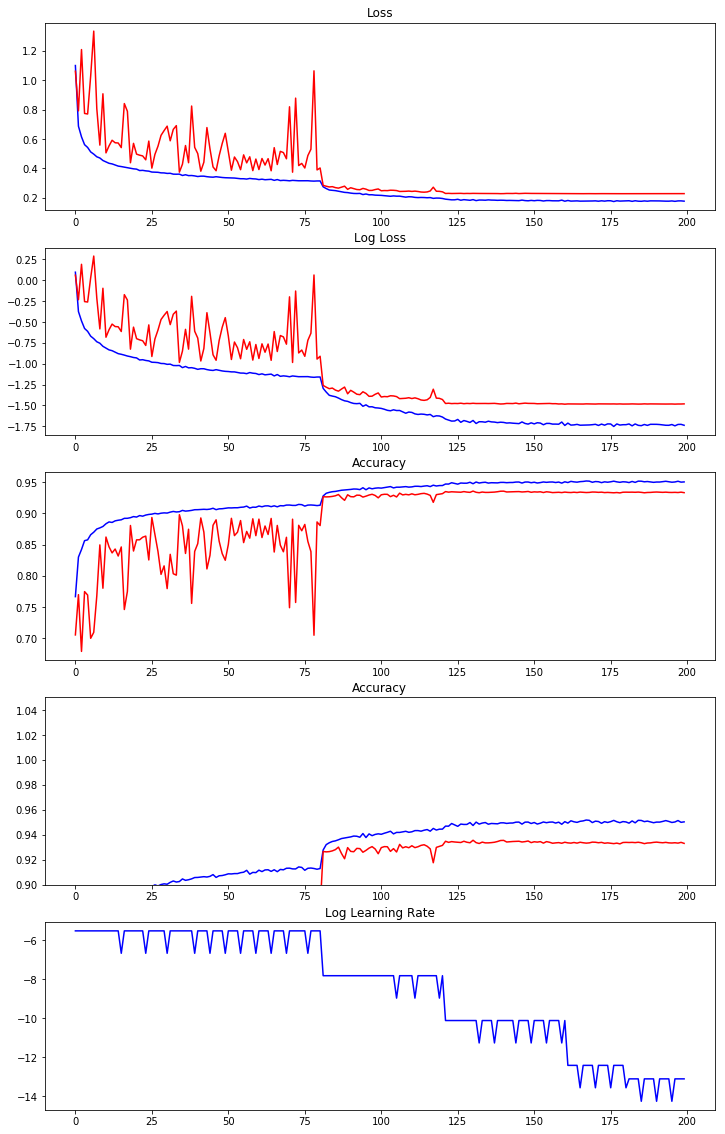

In [4]:
fig, axes = plt.subplots(5, 1, figsize=(12, 20), squeeze=True)
axes[0].set_title("Loss")
axes[0].plot(history.history["loss"], c="b")
axes[0].plot(history.history["val_loss"], c="r")

axes[1].set_title("Log Loss")
axes[1].plot(np.log(history.history["loss"]), c="b")
axes[1].plot(np.log(history.history["val_loss"]), c="r")

axes[2].set_title("Accuracy")
axes[2].plot(history.history["acc"], c="b")
axes[2].plot(history.history["val_acc"], c="r")

axes[3].set_title("Accuracy")
axes[3].set_ylim((0.90, 1.05))
axes[3].plot(history.history["acc"], c="b")
axes[3].plot(history.history["val_acc"], c="r")

axes[4].set_title("Log Learning Rate")
axes[4].plot(np.log(history.history["lr"]), c="b")

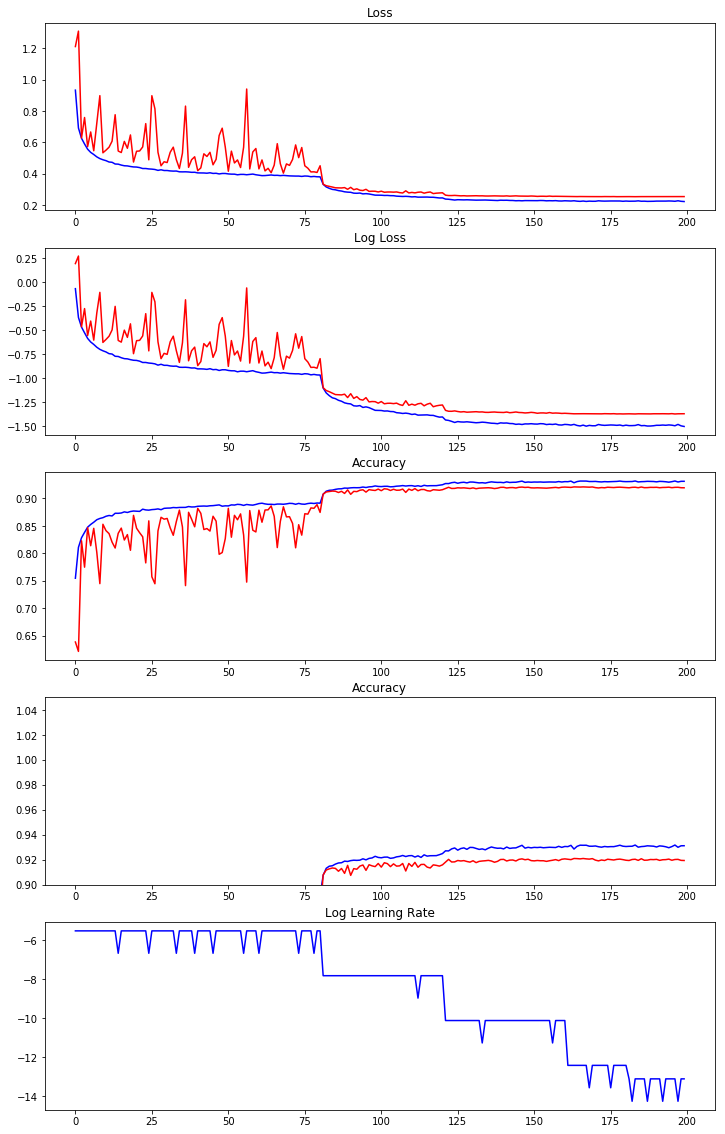

In [20]:
fig, axes = plt.subplots(5, 1, figsize=(12, 20), squeeze=True)
axes[0].set_title("Loss")
axes[0].plot(history.history["loss"], c="b")
axes[0].plot(history.history["val_loss"], c="r")

axes[1].set_title("Log Loss")
axes[1].plot(np.log(history.history["loss"]), c="b")
axes[1].plot(np.log(history.history["val_loss"]), c="r")

axes[2].set_title("Accuracy")
axes[2].plot(history.history["acc"], c="b")
axes[2].plot(history.history["val_acc"], c="r")

axes[3].set_title("Accuracy")
axes[3].set_ylim((0.90, 1.05))
axes[3].plot(history.history["acc"], c="b")
axes[3].plot(history.history["val_acc"], c="r")

axes[4].set_title("Log Learning Rate")
axes[4].plot(np.log(history.history["lr"]), c="b")